In [1]:
#AMDG
import os
import torch
import pandas as pd
import PIL
from PIL import Image
import skimage
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import glob
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from skimage import morphology
from subprocess import check_output
import os
from skimage.measure import label, regionprops

import matplotlib.patches as mpatches

In [2]:
class CellDataset(Dataset):
    # most of the content in this function is taken from 'Example Metric Implementation' kernel 
    # by 'William Cukierski'

    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_directory = os.path.join(self.root_dir, 'train')
        self.image_ids = check_output(["ls", self.images_directory]).decode('utf8').split()
        
    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_name = self.image_ids[idx]
        image_file = os.path.join(self.images_directory,  image_name,  'images',  image_name + '.png')
        mask_files = os.path.join(self.images_directory,  image_name,  'masks', '*.png')
        
        image = skimage.io.imread(image_file)
        masks = skimage.io.imread_collection(mask_files).concatenate()
        
        return image, masks
        


In [3]:
dataset = CellDataset('/home/rbanalagay/projects/datasciencebowl/')
dataloader = DataLoader(dataset)


In [4]:
all_st_devs = []
dark_images = []
light_images = []
color_images = []
for i, (image, masks) in enumerate(dataloader):
    st_dev_image = np.std(image[0,:,:,0:3], -1)
    if np.sum(st_dev_image) < 5:
        if np.median(image) < 128:
            dark_images.append(i)
        else:
            light_images.append(i)
    else:
        color_images.append(i)


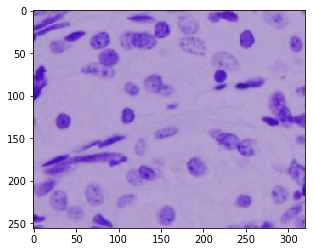

In [8]:
image_type = color_images
idx = np.random.randint(len(image_type))
image, masks = dataset[image_type[idx]]
plt.imshow(image)
plt.show()


/usr/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


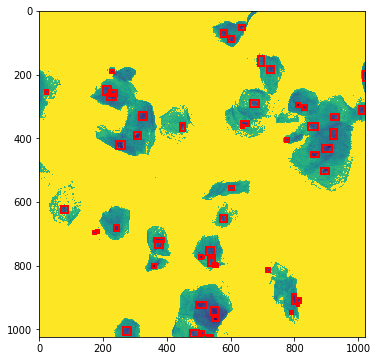

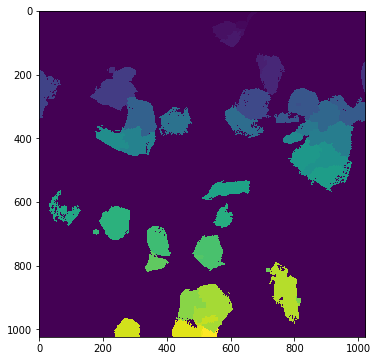

In [7]:
from skimage.filters import threshold_otsu
from skimage.morphology import watershed, disk
from scipy import ndimage
from skimage.feature import peak_local_max
import scipy
from skimage.filters import rank
from scipy import ndimage as ndi


image_type = light_images
idx = np.random.randint(len(image_type))
image, masks = dataset[image_type[idx]]
image = image[:, :, 0]
thresh = threshold_otsu(image)
image[image > thresh] = 255

markers = np.zeros(image.shape)
gradient = rank.gradient(image / 255., disk(2))

num_masks = masks.shape[0]
full_mask_image = np.zeros(image.shape)


fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image)
for mask_ind in range(0, num_masks):
    full_mask_image[masks[mask_ind, :, :] > 0] = 255
    for region in regionprops(masks[mask_ind, :, :]):
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr, 
                                  fill=False, edgecolor='red', linewidth=2)
        center_row, center_col = region.centroid
#         markers[masks[mask_ind, :, :] > 0] =  mask_ind
        markers[minr:maxr, minc:maxc] =  mask_ind
        ax.add_patch(rect)
        
markers = ndi.label(markers)[0]
    
plt.figure()
labels = watershed(gradient, markers, mask=image<255)
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(labels)

# plt.imshow(labels)
plt.show()

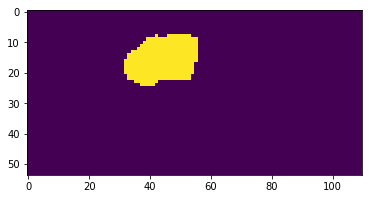

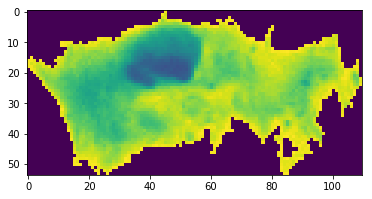

In [7]:
cell_to_show = np.random.randint(1, np.amax(labels) + 1)
for cell_num in range(1, np.amax(labels) + 1):
    invalid_pixels = (labels != cell_num)
    segmented = np.copy(image)
    cell_segmentation = np.copy(labels)
    cell_segmentation[invalid_pixels] = 0
    minr, minc, maxr, maxc = regionprops(cell_segmentation)[0].bbox
    segmented[invalid_pixels] = 0
    cell_cropped = segmented[minr:maxr, minc:maxc]


    nucleus_segmented = np.copy(full_mask_image)
    nucleus_segmented[invalid_pixels] = 0
    nucleus_cropped = nucleus_segmented[minr:maxr, minc:maxc]
    
    if cell_num == cell_to_show:
        plt.imshow(nucleus_cropped)
        plt.figure()
        plt.imshow(cell_cropped)
        
plt.show()



In [8]:
directory = '/home/rbanalagay/projects/datasciencebowl/cellprototypes'
if not os.path.exists(directory):
    os.makedirs(directory)
image_type = light_images

all_cells = []
all_nuclei = []

for idx in range(len(image_type)):
    image, masks = dataset[image_type[idx]]
    image = image[:, :, 0]
    thresh = threshold_otsu(image)
    image[image > thresh] = 255

    markers = np.zeros(image.shape)
    gradient = rank.gradient(image / 255., disk(2))

    num_masks = masks.shape[0]
    full_mask_image = np.zeros(image.shape)


    for mask_ind in range(0, num_masks):
        full_mask_image[masks[mask_ind, :, :] > 0] = 255
        for region in regionprops(masks[mask_ind, :, :]):
            minr, minc, maxr, maxc = region.bbox
            markers[minr:maxr, minc:maxc] =  mask_ind

    markers = ndi.label(markers)[0]

    labels = watershed(gradient, markers, mask=image<255)

    for cell_num in range(1, np.amax(labels) + 1):
        invalid_pixels = (labels != cell_num)
        segmented = np.copy(image)
        cell_segmentation = np.copy(labels)
        cell_segmentation[invalid_pixels] = 0
        minr, minc, maxr, maxc = regionprops(cell_segmentation)[0].bbox
        segmented[invalid_pixels] = 0
        cell_cropped = segmented[minr:maxr, minc:maxc]


        nucleus_segmented = np.copy(full_mask_image)
        nucleus_segmented[invalid_pixels] = 0
        nucleus_cropped = nucleus_segmented[minr:maxr, minc:maxc]
        
        all_cells.append(cell_cropped)
        all_nuclei.append(nucleus_cropped)
        
np.savez(directory + '/cells', *all_cells)
np.savez(directory + '/nuclei', *all_nuclei)
    


/usr/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


1014


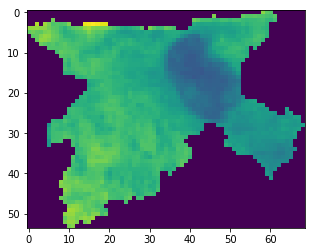

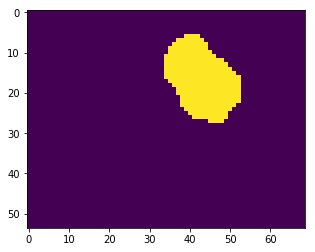

In [9]:

cells = np.load(directory + '/cells.npz')
nuclei = np.load(directory + '/nuclei.npz')

index = np.random.randint(len(cells.files))

print(len(cells.files))
plt.imshow(cells['arr_' + str(index)])
plt.figure()
plt.imshow(nuclei['arr_' + str(index)])
plt.show()

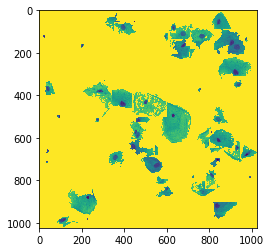

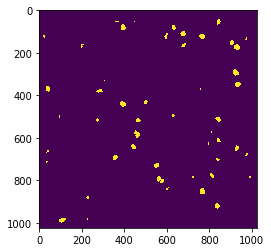

In [10]:

from torchvision import transforms


IMAGE_WIDTH = 1024
IMAGE_HEIGHT = 1024

fake_image = np.zeros((IMAGE_HEIGHT, IMAGE_WIDTH))
fake_mask = np.zeros((IMAGE_HEIGHT, IMAGE_WIDTH))


num_cells = int(max(np.random.normal(50, 10), 10))

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation([0, 360]),
    
])
for i in range(num_cells):
#     if i > 0:
#         break
    index = np.random.randint(len(cells.files))
    cell = cells['arr_' + str(index)]
#     cell = Image.fromarray(cells['arr_' + str(index)])
#     plt.imshow(cell)
#     plt.figure()
#     cell = transform(cell)
#     plt.imshow(np.copy(cell))
#     plt.figure()
    
#     cell = np.array(cell)
    
    nucleus = nuclei['arr_' + str(index)]
    
    cell_height, cell_width = cell.shape
    max_row = IMAGE_HEIGHT - cell_height
    max_col = IMAGE_WIDTH - cell_width
    
    x_loc = np.random.randint(max_col)
    y_loc = np.random.randint(max_row)
    
    fake_image[y_loc:(y_loc + cell_height), x_loc:(x_loc + cell_width)] = cell
    fake_mask[y_loc:(y_loc + cell_height), x_loc:(x_loc + cell_width)] = nucleus
    
    
fake_image[fake_image == 0] = 255
plt.imshow(fake_image)
plt.figure()
plt.imshow(fake_mask)
plt.show()